# Geno-VAE

Arun Durvasula

This notebook contains code for creating a variational autoencoder that learns how to generate data from the coalescent. It borrows code from the Keras examples directory.

First things first let's load packages:

In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import msprime

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import sklearn as sk
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline  

plt.style.use('ggplot')

Using TensorFlow backend.


# Simulation

We need data to train on. Here we generate data from the coalescent using msprime. The demography is a simple pants model with a very old split time and a low $N_e$ to ensure the populations undergo a lot of differentiation (to make things easy on ourselves). The output is a genotype matrix.

In [2]:
POP1_SAMPLE_SIZE=25000 # Number of samples from population 1
POP2_SAMPLE_SIZE=25000 # Number of samples from population 2
length=50000 # 100KB of sequence

mutation_rate=2e-8
recombination_rate=2e-8
NA=1000
N1=1000 # Population 1 size (diploid individuals)
N2=1000 # Population 2 size
M=0 # Migration rate between pop1 and pop2
SPLIT_TIME=15000 #Split time between pop1 and pop2 in generations

population_configurations = [
    msprime.PopulationConfiguration(sample_size=POP1_SAMPLE_SIZE, initial_size=N1),
    msprime.PopulationConfiguration(sample_size=POP2_SAMPLE_SIZE, initial_size=N2)
]

migration_matrix = [
    [0, M],
    [M, 0]
]

demographic_events = [
    msprime.MassMigration(time=SPLIT_TIME, source=1, destination=0, proportion=1.0)
]

### Run the simulation
tree_sequence = msprime.simulate(
    Ne=NA,
    length=length,
    recombination_rate=recombination_rate,
    mutation_rate=mutation_rate,
    population_configurations=population_configurations,
    migration_matrix=migration_matrix,
    demographic_events=demographic_events)

shape = tree_sequence.get_num_mutations(), tree_sequence.get_sample_size()
A = np.empty(shape, dtype="u1")
for variant in tree_sequence.variants():
    A[variant.index] = variant.genotypes
print(A)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 1 1 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


# Prepare data

Normalize the genotype matrix and transpose it so we have individuals/haplotypes as the samples and genotypes as the features.

In [3]:
As = sk.preprocessing.scale(A)
print(As.shape)
x_train = As.T
print(x_train.shape[0])

(118, 50000)
50000


/Users/arun/anaconda3/envs/tf12/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# Set up VAE

Here we set up the variational autoencoder. We set the batch size to the number of individuals divided by 50 so we have many batch updates per epoch. We set the original dimensions of the NN to the number of SNPs. We set the hidden layer to ~$1/2$ of the number of SNPs, we train for 50 epochs and we set the variance of the normal distribution we sample from to be 1 so that it's a standard normal.

We also set `latent_dim` to 3, which is the number of latent dimensions for our VAE. This means that we are embedding into 3 dimensions and will need to sample 3 latent variables in order to generate a sample later on.

In [4]:
batch_size = int(x_train.shape[0]/50)
original_dim = int(x_train.shape[1])
latent_dim = 3
intermediate_dim = int(original_dim/2)
epochs = 50
epsilon_std = 1.0

# Set up networks

This code is taken directly from the Keras example, but I changed the activations from `relu` to `tanh`.

In [5]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='tanh')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling)([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='tanh')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='RMSProp', loss=None)

/Users/arun/anaconda3/envs/tf12/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


# Train it!

In [6]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Epoch 1/50
50000/50000 [==============================] - 0s - loss: -9.2694     
Epoch 2/50
50000/50000 [==============================] - 0s - loss: -137.2370     
Epoch 3/50
50000/50000 [==============================] - 0s - loss: -250.3498     
Epoch 4/50
50000/50000 [==============================] - 0s - loss: -362.5530     
Epoch 5/50
50000/50000 [==============================] - 0s - loss: -473.5900     
Epoch 6/50
50000/50000 [==============================] - 0s - loss: -572.7724     
Epoch 7/50
50000/50000 [==============================] - 0s - loss: -643.9134     
Epoch 8/50
50000/50000 [==============================] - 0s - loss: -706.6694     
Epoch 9/50
50000/50000 [==============================] - 0s - loss: -755.0437     
Epoch 10/50
50000/50000 [==============================] - 0s - loss: -779.7064     
Epoch 11/50
50000/50000 [==============================] - 0s - loss: -792.0797     
Epoch 12/50
50000/50000 [==============================] - 0s - loss: -803.1

# Sample generation

Here we generate samples from our trained model. If we sample uniformly across the range $(0,1)$ we won't see any population structure. Therefore, we sample from the edges of the range across the 3 latent variables. First we draw $5^3$ samples from 0.05-0.06, then we draw the same number of samples from 0.94-0.95.

In [7]:
n=5
grid_x = norm.ppf(np.linspace(0.05, 0.06, n))
grid_y = norm.ppf(np.linspace(0.05, 0.06, n))
grid_z = norm.ppf(np.linspace(0.05, 0.06, n))



generated_inds = []
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        for k, zi in enumerate(grid_z):
            z_sample = np.array([[xi, yi, zi]])
            x_decoded = generator.predict(z_sample)
            generated_inds.append(x_decoded[0])

n=5
grid_x = norm.ppf(np.linspace(0.94, 0.95, n))
grid_y = norm.ppf(np.linspace(0.94, 0.95, n))
grid_z = norm.ppf(np.linspace(0.94, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        for k, zi in enumerate(grid_z):
            z_sample = np.array([[xi, yi, zi]])
            x_decoded = generator.predict(z_sample)
            generated_inds.append(x_decoded[0])

# Comparison

Here we look at the orignial data and plot the PCA. 

(50000, 2)


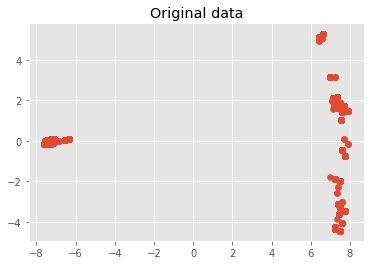

In [8]:
pca = PCA(n_components=2)
pca.fit(x_train)
v = pca.transform(x_train)
print(v.shape)
plt.scatter(v[:, 0], v[:, 1])
plt.title("Original data")

# Generated data

Here we look at the PCA for the generated data.

(250, 10)


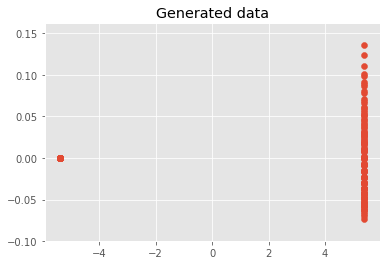

In [9]:
n_gen_ind = np.array(generated_inds)
pca = PCA(n_components=10)
pca.fit(n_gen_ind)
v = pca.transform(n_gen_ind)
print(v.shape)
plt.scatter(v[:, 0], v[:, 1])
plt.title("Generated data")

In [10]:
n_gen_ind.shape

(250, 118)

In [11]:
x_train.shape

(50000, 118)

# Visualizing the embedding

We can take a look at how the encoder embeds samples. We make the encoder embed the the training data and plot the latent variables against each other. One population is in blue, the other is in yellow. If the encoder learns a good representation, we should be able to see some separation between the two populations. 

In [12]:
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)

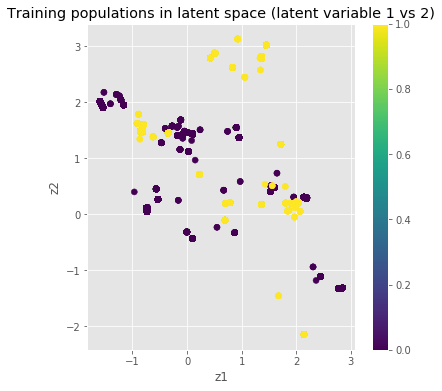

In [13]:
col = [0]*POP1_SAMPLE_SIZE + [1] *POP2_SAMPLE_SIZE
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=col)
plt.colorbar()
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Training populations in latent space (latent variable 1 vs 2)")
plt.show()

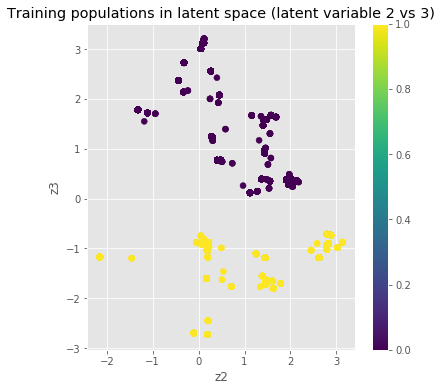

In [14]:
col = [0]*POP1_SAMPLE_SIZE + [1] *POP2_SAMPLE_SIZE
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 1], x_test_encoded[:, 2], c=col)
plt.colorbar()
plt.xlabel("z2")
plt.ylabel("z3")
plt.title("Training populations in latent space (latent variable 2 vs 3)")
plt.show()